In [4]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline


In [5]:
words = open('names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [8]:
def stoi_itos(words):
    vocab = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(vocab)}
    stoi['.']  = 0
    itos = {i:s for s,i in stoi.items()}
    return stoi, itos, len(words)


# Build Dataset
- read the names from the names.txt
- find the vocab or character in the name.txt file
- Chose the block-size and make example dataset from the names
- X: input to the model
- Y: output by the model during traing

In [33]:
import random
def build_dataset(file_path='names.txt', context_len = 3):
    words = open('names.txt').read().splitlines()
    random.shuffle(words)
    stoi,itos,vocab_size  = stoi_itos(words)
    X = []
    Y = []
    blocks_size  = context_len
    for w in words:
        
        context= [0]*blocks_size
        
        for char in w + '.': 
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            # print(''.join([ itos[char] for char in context]), '---> ', itos[ix])
            # print(context)
            context = context[1:] + [ix]
            # print(context)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    x1 = int(0.8*len(words))
    x2 = int(0.9*len(words))
    
    dataset ={'train': [X[0:x1] , Y[0:x1]], 'val': [X[x1:x2], Y[x1:x2]], 'test': [X[x2:], Y[x2:]]}
    return dataset


    

In [34]:
dataset = build_dataset(words)


# Initialize the Model
- initialize the generator using torch.Generator().manual_seed(number)
- Initialize the the embedding matrix C
- 

In [74]:
def initialize_model(vocab_size, emb_dim,Input_data, layers_dim = []):
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((vocab_size,emb_dim), generator=g)
    W1 = torch.randn((Input_data.shape[1]*emb_dim, layers_dim[0] ), generator=g)
    # print(W1.shape)
    b1 = torch.randn(layers_dim[0], generator=g)
    
    W2 = torch.randn((layers_dim[0],vocab_size), generator=g)*0.01
    b2 = torch.randn(vocab_size, generator=g)*0
    
    parameters = [C, W1,b1, W2,b2]
    return parameters

In [94]:
def model(X, parameters):
    emb = parameters[0][X]
    preact  =emb.view(-1,30)  @ parameters[1] + parameters[2]
    a1 = torch.tanh(preact)
    logits = a1 @ parameters[3] + parameters[4]
    return logits,a1, preact

In [95]:
def requires_grad(parameters):
    for p in parameters:
        p.requires_grad = True
    return parameters

# A very in-depth explination of how the tanh function issues of vanishing the gradient flow due to that most of its post activation values are closer to 1 and -1. and during backpropagation (1 - t**2).out.grad, (t is closer to -1 or 1) vanishes the gradients flowing backward towards the paramters #

In [96]:
import random
context_len = 3
data_path = 'names.txt'
vocab_size = 27
emb_dim=10
layers_dim = [300,27]
epochs = 90000
dataset = build_dataset(words)
Xtr,Ytr = dataset['train']
Xval, Yval = dataset['val']
Xtest, Ytest = dataset['test']
# num_examples = len(X)
# Xtr,Xval,Xtest = X[0:int(0.7*num_examples)], X[int(0.7*num_examples):int(0.9*num_examples)], X[int(0.9*num_examples): num_examples]
# Ytr,Yval,Ytest = Y[0:int(0.7*num_examples)], Y[int(0.7*num_examples):int(0.9*num_examples)], Y[int(0.9*num_examples): num_examples]

# print(Xtr.shape, Ytr.shape)
parameters = initialize_model(vocab_size, emb_dim, Xtr, layers_dim = layers_dim)
parameters = requires_grad(parameters)
# print(X.shape)
# print(Y.shape)

lre = torch.linspace(-3,0, epochs)
lrr = 10**lre

#Forward Pass
lri = []
lossi = []
stepi = []
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # print(Xtr[ix].shape)
    logits, h, preact = model(Xtr[ix], parameters)
    # print(logits.shape)
    # Calculate Loss
    loss = F.cross_entropy(logits, Ytr[ix])
    for p in parameters:
        p.grad = None
    
    # calculate the gradients
    loss.backward()
    
    #Gradient Descent
    lr = [0.1,0.01]
    if i<=30000:
        lr = lr[0]
    else:
        lr = lr[1]
    for p in parameters:
        p.data += -lr*p.grad
    lossi.append(loss.log10().item())
    lri.append(lr)
    stepi.append(i)
    break
print(loss.item())


3.2554805278778076


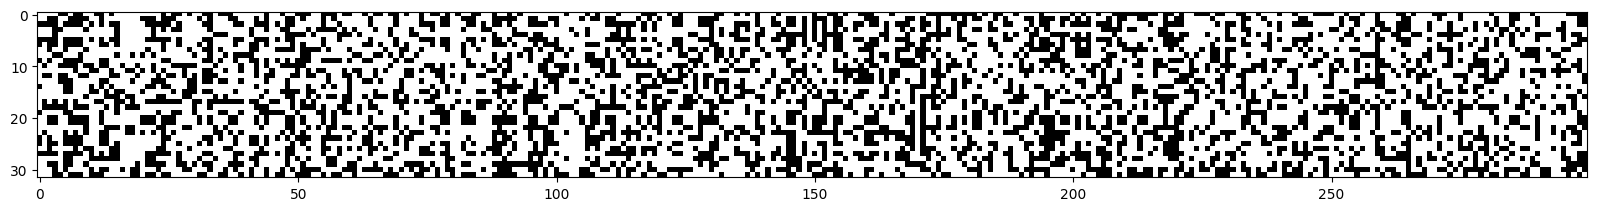

In [103]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

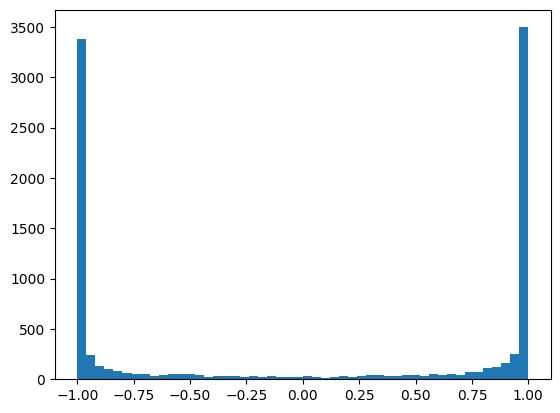

In [100]:
# logits[0]

plt.hist(h.view(-1).tolist(),50);


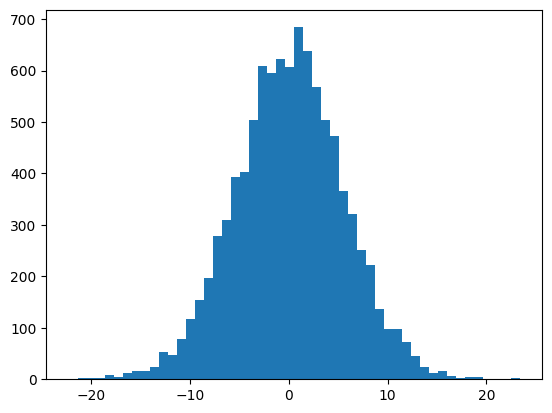

In [101]:
plt.hist(preact.view(-1).tolist(),50);

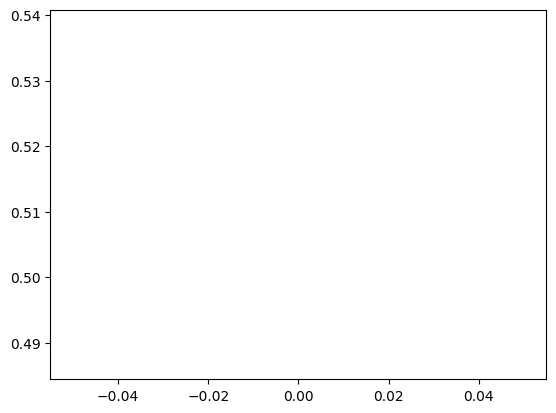

In [99]:
plt.plot(stepi, lossi)

In [41]:
logits = model(Xtr, parameters)
loss = F.cross_entropy(logits, Ytr)
loss.item()

1.9535527229309082

In [42]:
logits = model(Xval, parameters)
loss = F.cross_entropy(logits, Yval)
loss.item()

2.4519879817962646

In [43]:
logits = model(Xtest, parameters)
loss = F.cross_entropy(logits, Ytest)
loss.item()

2.466986894607544

In [62]:
# logits = torch.tensor([3.0,0.0,0.0,0.0])
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-0.7792, -0.3176,  0.6212, -1.1631]),
 tensor([0.1365, 0.2166, 0.5539, 0.0930]),
 tensor(0.5908))

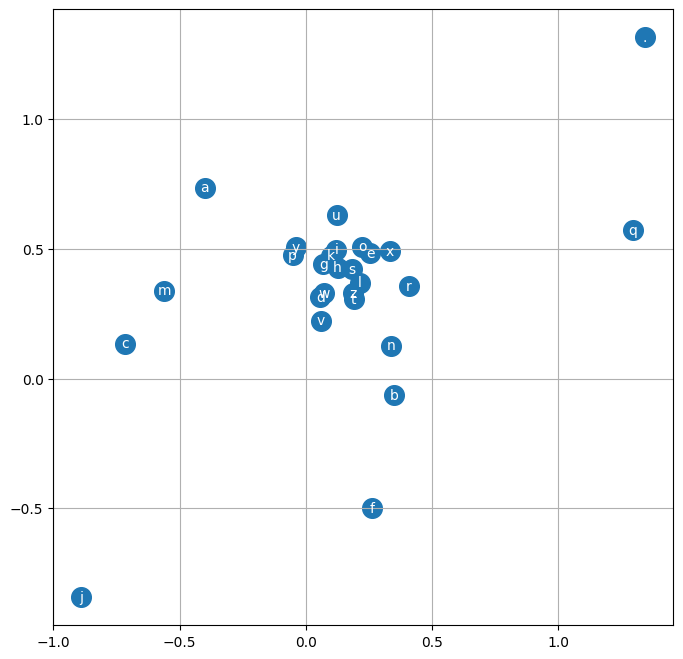

In [106]:
# This code was effect for the emb_dim=2
# # plt.figure()
# plt.figure(figsize=(8,8))
# plt.scatter(parameters[0][:,0].data, parameters[0][:,1].data, s=200)
# for i in range(parameters[0].shape[0]):
#     plt.text(parameters[0][i,0].item(), parameters[0][i,1].item(), itos[i], ha='center', va='center', color='white')
# plt.grid('minor')

In [46]:
import torch
g = torch.Generator().manual_seed(2147483647)
stoi,itos, vocab_size = stoi_itos(words)
for i in range(10):
    ix = 0
    out = []
    block_size = 3
    context = [0] * block_size 
    while True:
        emb = parameters[0][torch.tensor([context])]
        a1 = torch.tanh(emb.view(-1,30) @ parameters[1] + parameters[2])
        logits = a1 @ parameters[3] + parameters[4]
        probs = F.softmax(logits ,dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix==0:
            break
    print(''.join(out))

junrie.
jayce.
zophon.
yoa.
nya.
jhir.
toldashager.
kilania.
yanilee.
ashdeyah.


In [47]:
-torch.tensor(1/27.0).log()

tensor(3.2958)